In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.5381MHz', 'g23': '121.9492MHz'}


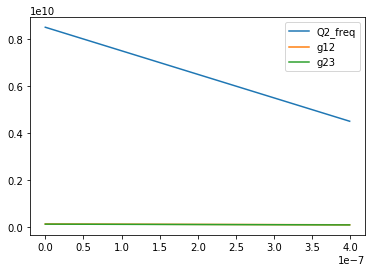

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

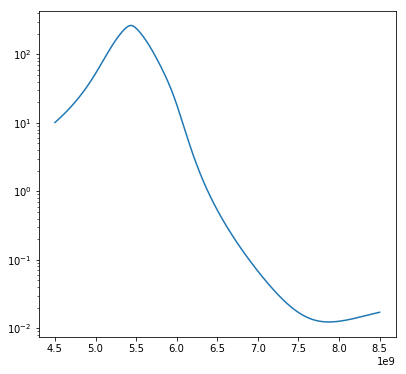

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib qt

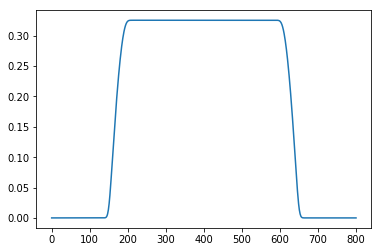

In [7]:
gate_time=30e-9
SRATE=10e9
total_len = gate_time + 50e-9
Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Cosine',t0=total_len/2,width=10e-9,plateau=40e-9,amplitude=0.3255,frequency=0,half_cosine=True)
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

In [9]:
%matplotlib inline

In [10]:
def cost_func(pulse_params,*args):
    gate_time,SRATE=args

    amplitude = pulse_params
    total_len = gate_time + 10e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Cosine',t0=total_len/2,width=gate_time,plateau=0e-9,amplitude=amplitude,frequency=0,half_cosine=True)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
        

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('amplitude:',amplitude)
    print('error:',1-fidelity)
    return 1 - fidelity



In [32]:
# SRATE=10e9
# gate_time_arr = np.arange(30e-9,60.1e-9,1e-9)

# gate_fidelity_cos = []
# gate_params_cos = []
# raw_initial_seeds=np.array([0.28])
# for gate_time in gate_time_arr:
#     time_start = time.time()
#     DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})

#     gate_fidelity_cos.append(DATA.fun)
#     gate_params_cos.append(DATA.x)
#     raw_initial_seeds =DATA.x*0.92
#     print('gate time',gate_time)
#     print('fidelity',DATA.fun)
# #     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\params_cos.txt',gate_params_cos )
# #     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\error_cos.txt',gate_fidelity_cos )
# #     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\gate_time_cos.txt',gate_time_arr )

In [11]:
SRATE=10e9
gate_time_arr = np.arange(12e-9,15.1e-9,1e-9)

gate_fidelity_cos = []
gate_params_cos = []
raw_initial_seeds=np.array([0.28])
for gate_time in gate_time_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})

    gate_fidelity_cos.append(DATA.fun)
    gate_params_cos.append(DATA.x)
    raw_initial_seeds =DATA.x*0.92
    print('gate time',gate_time)
    print('fidelity',DATA.fun)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\cos_pulse\params_cos_12_15.txt',gate_params_cos )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\cos_pulse\error_cos_12_15.txt',gate_fidelity_cos )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\cos_pulse\gate_time_cos_12_15.txt',gate_time_arr )
   

amplitude: [0.28]
error: 0.6945340399153466
amplitude: [0.294]
error: 0.6181004043475126
amplitude: [0.308]
error: 0.42285136526907674
amplitude: [0.322]
error: 0.2500311511692177
amplitude: [0.35]
error: 0.6700198830460459
amplitude: [0.308]
error: 0.42285136526907674
amplitude: [0.336]
error: 0.30041022775235793
amplitude: [0.329]
error: 0.23973163450035995
amplitude: [0.336]
error: 0.30041022775235793
amplitude: [0.3255]
error: 0.2408132041284704
amplitude: [0.3325]
error: 0.25831219645760795
amplitude: [0.32725]
error: 0.2387109369137974
amplitude: [0.3255]
error: 0.24081006527977955
amplitude: [0.328125]
error: 0.23867704810976031
amplitude: [0.329]
error: 0.23973163450035995
amplitude: [0.3276875]
error: 0.2385716703263544
amplitude: [0.32725]
error: 0.2387028237636677
amplitude: [0.32790625]
error: 0.23859309662243644
amplitude: [0.32746875]
error: 0.23862135139921548
amplitude: [0.32779688]
error: 0.23857487188261972
amplitude: [0.32757812]
error: 0.23858288272270445
amplitude:

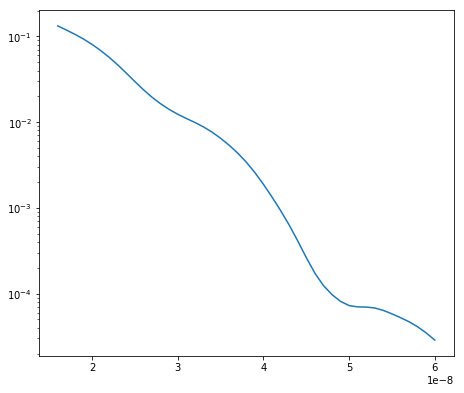

In [26]:
fig = plt.figure(figsize=[8,6.4])
ax = fig.add_axes([0.15,0.15,0.72,0.75])
ax.plot(gate_time_arr,gate_fidelity_cos)

ax.set_yscale('log')